In [1]:
! git clone https://github.com/amnghd/Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (3/3), done.


#Put All Poems in List of Data Series#
Each Data Serie is made of verses(not santzas).

In [2]:
import pandas as pd
import os
poems_df_list = []
poets = [i[:-9] for i in os.listdir('Persian_poems_corpus/normalized')]
for poet in poets:
  df = pd.read_csv(os.path.join('Persian_poems_corpus/normalized' ,poet+'_norm.txt'), delimiter = "\n", header=None)
  if len(df)%2==1:
    dx = df.iloc[::2].reset_index(drop=True)[0:-1][0]+' '+df.iloc[1::2].reset_index(drop=True)[0]
  else:
    dx = df.iloc[::2].reset_index(drop=True)[0]+' '+df.iloc[1::2].reset_index(drop=True)[0]
  poems_df_list.append(dx)
  del df
  del dx

#Choose 10 Poets #
I choose 10 poets that the number of verses of their poems is near each other

In [3]:
import numpy as np
len_poems = []
for poem in poems_df_list:
  len_poems.append(len(poem))
len_poems_np = np.array(len_poems)
my_poets = [poets[i] for i in len_poems_np.argsort()[-25:-15].tolist()]

my_poems_df_list = [poems_df_list[i] for i in len_poems_np.argsort()[-25:-15].tolist()]
print(my_poems_df_list)
print(my_poets)

[0       ای غره ماه از اثر صنع تو غرا وی طره شب از دم ل...
1       نوک قلم صنع تودر مبدا فطرت انگیخته برصفحه کن ص...
2       سجاده نشینان نه ایوان فلک را حکم تو فروزنده قن...
3       هم رازق بی ریبی و هم خالق بی عیب هم ظاهر پنهان...
4       مامور تو از برگ سمن تا بسمندر مصنوع تو از تحت ...
                              ...                        
8841    روشنست این کانکه از سودای او در آتشیم شمع عشقش...
8842    دل بدلداری سپارد هر که صاحبدل بود کانکه جانی ب...
8843    آشنایی را بچشم خویش دیدن مشکلست زانکه او دیدار...
8844    هر که داند کاندرین ره مقصد کلی یکیست هر زمانی ...
8845    دل منه بر ملک جم خواجو که شادروان عمر با فسونی...
Name: 0, Length: 8846, dtype: object, 0       سپاس و آفرین آن پادشا را که گیتی را پدید آورد ...
1       بدو زیباست ملک و پادشایی که هر گز ناید از ملکش...
2       خدای پاک و بی همتا و بی یار هم از اندیشه دور و...
3       نه بتواند مرو را چشم دیدن نه اندیشه درو داند ر...
4       نه نقصانی پذیرد همچو جوهر نه زان گردد مرو را ح...
                              ...

#Finding Maximum Number of Tokens In All Verses of All poets#

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.0 MB/s eta 0:00:00


In [5]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [6]:
max_verse_length = 0
for my_poem_df in my_poems_df_list:
    for my_verse in my_poem_df:
        max_verse_length = max(max_verse_length, len(tokenizer.encode(my_verse, add_special_tokens=True)))

max_verse_length 


31

In [7]:
import torch
input_ids = []
attention_masks = []
labels = []

for poet_label, my_poem_df in enumerate(my_poems_df_list):
      for my_verse in my_poem_df:
          encoded_dict = tokenizer.encode_plus(
                            my_verse,                      
                            add_special_tokens = True, 
                            max_length = max_verse_length ,    
                            pad_to_max_length = True,
                            return_attention_mask = True, 
                            return_tensors = 'pt',   
                    )
        
          input_ids.append(encoded_dict['input_ids'])
          attention_masks.append(encoded_dict['attention_mask'])
          labels.append(poet_label)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
print(input_ids.shape)
print(attention_masks.shape)
print(labels.shape)

torch.Size([110456, 31])
torch.Size([110456, 31])
torch.Size([110456])


In [46]:
from torch.utils.data import TensorDataset, random_split
torch.manual_seed(42)
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 *len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset,val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [47]:
print(len(train_dataset))
train_dataset[0]

77319


(tensor([    2,  2958,  2801,  6052,  5966,  6722,  2974,  6778, 61474, 11543,
          8540,  2800,  6512,  3306,     4,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
 tensor(6))

In [48]:
print(len(val_dataset))
val_dataset[0]

16568


(tensor([    2,  2911,  2896,  3010,  2848,  8345,  5355,  2867,  6722,  1379,
          4929,  1363,  2861, 61585,  2860,  2848,  3525, 21886,  2009,  3073,
         22838, 19444,     4,     0,     0,     0,     0,     0,     0,     0,
             0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0]),
 tensor(7))

In [49]:
print(len(test_dataset))
test_dataset[0]

16569


(tensor([    2, 25953, 93987, 18969,  5728,  2800,  2883,  2808, 38402,  3288,
          9052,  4035,  3239, 11782,  3048,  4969,  4694, 24791,  2835,     4,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0]),
 tensor(0))

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Part1 : Linear Tuned Model#

In [51]:
from transformers import BertForSequenceClassification, BertConfig
from prettytable import PrettyTable
import torch.nn as nn
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
model_linear = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
for param in model_linear.parameters():
    param.requires_grad = False
model_linear.pooler = nn.Linear(768, 10)
model_linear.to(device)
params = count_parameters(model_linear)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| pooler.weight |    7680    |
|  pooler.bias  |     10     |
+---------------+------------+
Total Trainable Params: 7690


In [52]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        labels = data[2].to(device)
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)

        model.train()
        pred = model(input_ids).pooler_output.permute((1, 0, 2))[0]
        loss = loss_fn(pred, labels) 

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(input_ids)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.to(device)
            model.eval()

            pred = model(input_ids).pooler_output.permute((1, 0, 2))[0]
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

In [53]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)  

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [54]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
epochs = 5
optimizer = torch.optim.Adam(model_linear.parameters(), lr = learning_rate)
val_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_linear, loss_fn, optimizer)
    val_accuracy.append(test_loop(val_dataloader, model_linear, loss_fn)[0])
    if np.argmax(val_accuracy) ==len(val_accuracy)-1:
      torch.save(model_linear,' model_linear.pth')

      
print("Done!")

Epoch 1
-------------------------------
loss: 2.416190  [    0/77319]
loss: 2.098367  [ 6400/77319]
loss: 2.127754  [12800/77319]
loss: 2.120794  [19200/77319]
loss: 1.923543  [25600/77319]
loss: 1.967951  [32000/77319]
loss: 1.967956  [38400/77319]
loss: 1.987794  [44800/77319]
loss: 1.848934  [51200/77319]
loss: 1.958863  [57600/77319]
loss: 1.832809  [64000/77319]
loss: 1.890755  [70400/77319]
loss: 2.095255  [76800/77319]
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.873593 

Epoch 2
-------------------------------
loss: 2.075663  [    0/77319]
loss: 1.880057  [ 6400/77319]
loss: 1.877188  [12800/77319]
loss: 1.868775  [19200/77319]
loss: 1.918449  [25600/77319]
loss: 1.998672  [32000/77319]
loss: 1.995187  [38400/77319]
loss: 1.937525  [44800/77319]
loss: 1.965743  [51200/77319]
loss: 1.996849  [57600/77319]
loss: 1.935534  [64000/77319]
loss: 1.914544  [70400/77319]
loss: 1.825345  [76800/77319]
Test Error: 
 Accuracy: 36.1%, Avg loss: 1.811970 

Epoch 3
----------------------------

#Download The Best Linear Model
If you don't have time for training, you can run this section.

In [ ]:
!gdown 1GqAZYqalinJndjXdx95iHpaD8T8qg7-n

##Acuuracy,Loss, micro F1 Score & Confusion Matrix of Test Data On Linear Model##

In [56]:
model_linear = torch.load('/content/ model_linear.pth')

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def test_condition(dataloader, model):
         pred_list=[]
         true_list=[]
         with torch.no_grad():
          for data in dataloader:
              input_ids = data[0].to(device)
              input_mask = data[1].to(device)
              labels = data[2].to(device)
              input_ids = input_ids.to(device)
              input_mask = input_mask.to(device)
              labels = labels.to(device)
              model.eval()
              pred = model(input_ids).pooler_output.permute((1, 0, 2))[0]

              pred_list.extend(pred.argmax(1).data.cpu().numpy())
              true_list.extend(labels.data.cpu().numpy())
          return  true_list, pred_list
true_list, pred_list =test_condition(test_dataloader, model_linear)

In [58]:
test_accuracy_loss = test_loop(test_dataloader, model_linear, loss_fn)
print(f"Accuracy of Test Set On Linear Model Is:{test_accuracy_loss[0]}")
print(f"Loss of Test Set On Linear Model Is:{test_accuracy_loss[1]}")

Test Error: 
 Accuracy: 37.9%, Avg loss: 1.772233 

Accuracy of Test Set On Linear Model Is:0.37938318546683564
Loss of Test Set On Linear Model Is:1.772232522375335


In [59]:
print(f"micro F1 Score of Test Set On Linear Model Is:{f1_score(true_list, pred_list, average='micro')}")

micro F1 Score of Test Set On Linear Model Is:0.37938318546683564


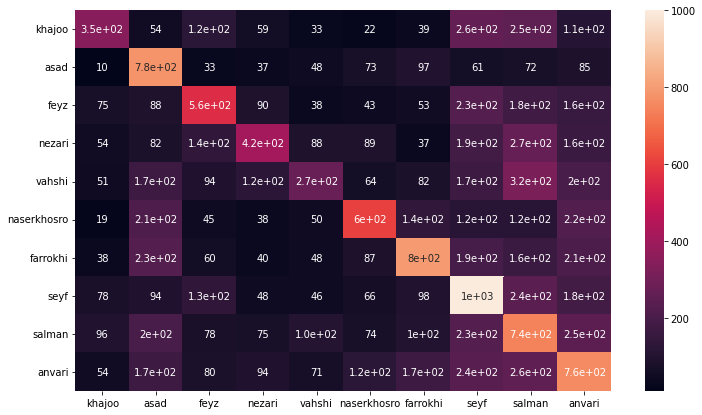

In [60]:
cf_matrix = confusion_matrix(true_list, pred_list)
df_cm = pd.DataFrame(cf_matrix, index = my_poets,columns = my_poets)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


#Part2: Fine Tuned Model#

In [86]:
model_fine_tuned = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased", 
    num_labels = 10, 
    output_attentions = False, 
    output_hidden_states = False)
params = count_parameters(model_fine_tuned)
model_fine_tuned.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

+---------------------------------------------------------+------------+
|                         Modules                         | Parameters |
+---------------------------------------------------------+------------+
|          bert.embeddings.word_embeddings.weight         |  76800000  |
|        bert.embeddings.position_embeddings.weight       |   393216   |
|       bert.embeddings.token_type_embeddings.weight      |    1536    |
|             bert.embeddings.LayerNorm.weight            |    768     |
|              bert.embeddings.LayerNorm.bias             |    768     |
|     bert.encoder.layer.0.attention.self.query.weight    |   589824   |
|      bert.encoder.layer.0.attention.self.query.bias     |    768     |
|      bert.encoder.layer.0.attention.self.key.weight     |   589824   |
|       bert.encoder.layer.0.attention.self.key.bias      |    768     |
|     bert.encoder.layer.0.attention.self.value.weight    |   589824   |
|      bert.encoder.layer.0.attention.self.value.bi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [87]:
def fine_tuned_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        labels = data[2].to(device)
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)
        model.train()

        loss = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).loss
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(input_ids)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def fine_tuned_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data[0].to(device)
            input_mask = data[1].to(device)
            labels = data[2].to(device)
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.to(device)
            model.eval()

            loss = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).loss
            pred = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).logits

            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1).flatten() == labels.flatten()).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

#Training Fine Tuned Model With ADAM#

In [88]:
loss_fn = nn.CrossEntropyLoss()
epochs = 2
optimizer = torch.optim.Adam(model_fine_tuned.parameters(), lr = 1e-4)  
val_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    fine_tuned_train_loop(train_dataloader,model_fine_tuned, loss_fn, optimizer)
    val_accuracy.append(fine_tuned_test_loop(val_dataloader, model_fine_tuned, loss_fn)[0])
    if np.argmax(val_accuracy) ==len(val_accuracy)-1:
      torch.save(model_fine_tuned,' model_fine_tuned.pth')

      
print("Done!")

Epoch 1
-------------------------------
loss: 2.357162  [    0/77319]
loss: 1.847415  [ 6400/77319]
loss: 1.452013  [12800/77319]
loss: 1.795703  [19200/77319]
loss: 1.258586  [25600/77319]
loss: 1.345260  [32000/77319]
loss: 1.213656  [38400/77319]
loss: 1.316798  [44800/77319]
loss: 1.385175  [51200/77319]
loss: 1.017192  [57600/77319]
loss: 1.399873  [64000/77319]
loss: 1.330047  [70400/77319]
loss: 1.067568  [76800/77319]
Test Error: 
 Accuracy: 63.8%, Avg loss: 1.064743 

Epoch 2
-------------------------------
loss: 0.645598  [    0/77319]
loss: 0.865569  [ 6400/77319]
loss: 0.542449  [12800/77319]
loss: 0.840033  [19200/77319]
loss: 0.996147  [25600/77319]
loss: 0.939151  [32000/77319]
loss: 0.821114  [38400/77319]
loss: 0.762390  [44800/77319]
loss: 0.849673  [51200/77319]
loss: 0.852582  [57600/77319]
loss: 0.718231  [64000/77319]
loss: 0.636364  [70400/77319]
loss: 0.937083  [76800/77319]
Test Error: 
 Accuracy: 67.1%, Avg loss: 1.032046 

Done!


#Download The Best Fine Tuned Model (Trained With ADAM)
If you don't have time for training, you can run this section.

In [ ]:
!gdown 1-CoxILLjpfJLEI6Ld3nECLsfr3qJDaUj

##Acuuracy,Loss, micro F1 Score & Confusion Matrix of Test Data On  Fine Tuned Model (Trained With ADAM)##

In [ ]:
model_fine_tuned = torch.load('/content/ model_fine_tuned.pth')

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def fine_tuned_test_condition(dataloader, model):
         pred_list=[]
         true_list=[]
         with torch.no_grad():
          for data in dataloader:
              input_ids = data[0].to(device)
              input_mask = data[1].to(device)
              labels = data[2].to(device)
              input_ids = input_ids.to(device)
              input_mask = input_mask.to(device)
              labels = labels.to(device)
              pred = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).logits

              pred_list.extend(pred.argmax(1).flatten().data.cpu().numpy())
              true_list.extend(labels.flatten().data.cpu().numpy())
          return  true_list, pred_list
true_list, pred_list =fine_tuned_test_condition(test_dataloader, model_fine_tuned)

In [90]:
test_accuracy_loss = fine_tuned_test_loop(test_dataloader, model_fine_tuned, loss_fn)
print(f"Accuracy of Test Set On Fine Tuned Model(Trained With ADAM) Is:{test_accuracy_loss[0]}")
print(f"Loss of Test Set On Fine Tuned Model(Trained With ADAM) Is:{test_accuracy_loss[1]}")

Test Error: 
 Accuracy: 66.9%, Avg loss: 1.055183 

Accuracy of Test Set On Fine Tuned Model(Trained With ADAM) Is:0.6692618745850685
Loss of Test Set On Fine Tuned Model(Trained With ADAM) Is:1.0551828044721978


In [91]:
print(f"micro F1 Score of Test Set On Fine Tuned Model(Trained With ADAM) Is:{f1_score(true_list, pred_list, average='micro')}")

micro F1 Score of Test Set On Fine Tuned Model(Trained With ADAM) Is:0.6692618745850685


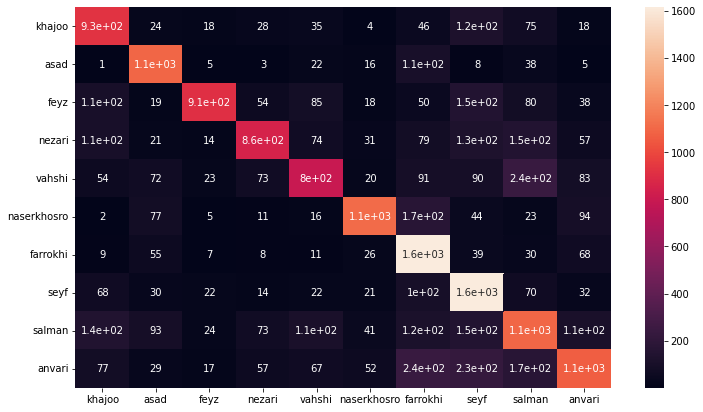

In [92]:
cf_matrix = confusion_matrix(true_list, pred_list)
df_cm = pd.DataFrame(cf_matrix, index = my_poets,columns = my_poets)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


In [75]:
def sgd_fine_tuned_train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, data in enumerate(dataloader):
        input_ids = data[0].to(device)
        input_mask = data[1].to(device)
        labels = data[2].to(device)
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        labels = labels.to(device)
        model.train()

        loss = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).loss
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(input_ids)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

#Training Fine Tuned Model With SGD#

In [76]:
sgd_model_fine_tuned = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased", 
    num_labels = 10, 
    output_attentions = False, 
    output_hidden_states = False)
sgd_model_fine_tuned.to(device)
loss_fn = nn.CrossEntropyLoss()
epochs = 2
optimizer = torch.optim.SGD(sgd_model_fine_tuned.parameters(), lr = 1e-2) 
val_accuracy = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    sgd_fine_tuned_train_loop(train_dataloader,sgd_model_fine_tuned, loss_fn, optimizer)
    val_accuracy.append(fine_tuned_test_loop(val_dataloader, sgd_model_fine_tuned, loss_fn)[0])
    if np.argmax(val_accuracy) ==len(val_accuracy)-1:
      torch.save(sgd_model_fine_tuned,' sgd_model_fine_tuned.pth')

print("Done!")

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

Epoch 1
-------------------------------
loss: 2.368702  [    0/77319]
loss: 2.263931  [ 6400/77319]
loss: 2.247746  [12800/77319]
loss: 2.194960  [19200/77319]
loss: 2.167892  [25600/77319]
loss: 2.094162  [32000/77319]
loss: 1.983481  [38400/77319]
loss: 2.095783  [44800/77319]
loss: 1.917590  [51200/77319]
loss: 1.803565  [57600/77319]
loss: 2.030727  [64000/77319]
loss: 1.962251  [70400/77319]
loss: 1.936428  [76800/77319]
Test Error: 
 Accuracy: 33.1%, Avg loss: 1.883281 

Epoch 2
-------------------------------
loss: 1.992633  [    0/77319]
loss: 1.852898  [ 6400/77319]
loss: 1.774832  [12800/77319]
loss: 1.881730  [19200/77319]
loss: 1.977770  [25600/77319]
loss: 1.890945  [32000/77319]
loss: 1.788455  [38400/77319]
loss: 1.912020  [44800/77319]
loss: 1.826871  [51200/77319]
loss: 1.843800  [57600/77319]
loss: 1.814231  [64000/77319]
loss: 1.906151  [70400/77319]
loss: 1.847154  [76800/77319]
Test Error: 
 Accuracy: 38.0%, Avg loss: 1.758521 

Done!


#Download The Best Fine Tuned Model (Trained With SGD)
If you don't have time for training, you can run this section.

In [ ]:
!gdown 1-RoxJgD_4Bo-g4xNYnxeA7yQ-un4lnY2

##Acuuracy,Loss, micro F1 Score & Confusion Matrix of Test Data On  Fine Tuned Model (Trained With SGD)##

In [ ]:
sgd_model_fine_tuned = torch.load('/content/ sgd_model_fine_tuned.pth')

In [77]:
true_list, pred_list =fine_tuned_test_condition(test_dataloader, sgd_model_fine_tuned)

In [79]:
test_accuracy_loss = fine_tuned_test_loop(test_dataloader, sgd_model_fine_tuned, loss_fn)
print(f"Accuracy of Test Set On Fine Tuned Model(Trained With SGD) Is:{test_accuracy_loss[0]}")
print(f"Loss of Test Set On Fine Tuned Model(Trained With SGD) Is:{test_accuracy_loss[1]}")

Test Error: 
 Accuracy: 38.4%, Avg loss: 1.754869 

Accuracy of Test Set On Fine Tuned Model(Trained With SGD) Is:0.3837890035608667
Loss of Test Set On Fine Tuned Model(Trained With SGD) Is:1.754869125524543


In [80]:
print(f"micro F1 Score of Test Set On Fine Tuned Model(Trained With SGD) Is:{f1_score(true_list, pred_list, average='micro')}")

micro F1 Score of Test Set On Fine Tuned Model(Trained With SGD) Is:0.38378900356086676


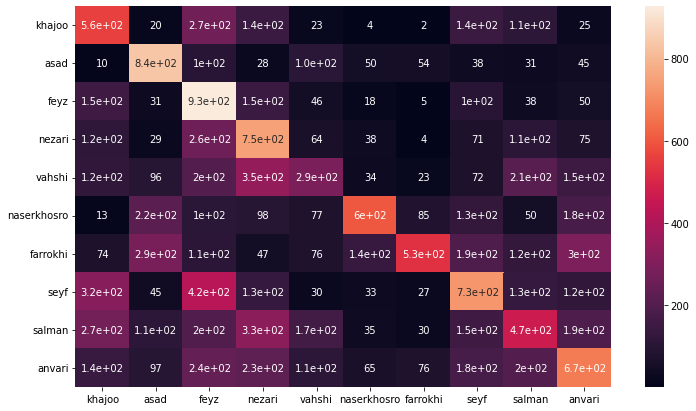

In [81]:
cf_matrix = confusion_matrix(true_list, pred_list)
df_cm = pd.DataFrame(cf_matrix, index = my_poets,columns = my_poets)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


#Perpelixity#

In [ ]:
import gc
del sgd_model_fine_tuned
gc.collect()##delete the useless model 

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

from transformers import AutoConfig, AutoTokenizer, AutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

In [117]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import numpy as np

from transformers import AutoConfig, AutoTokenizer, AutoModel

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

model_not_fine_tuned = BertForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased", 
    num_labels = 10, 
    output_attentions = False, 
    output_hidden_states = False)
model_not_fine_tuned.to(device)
        


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [123]:
def score(model, tokenizer, sentence,labels):
    encoded_dict = tokenizer.encode_plus(
                            sentence,                      
                            add_special_tokens = True, 
                            max_length = max_verse_length ,    
                            pad_to_max_length = True,
                            return_attention_mask = True, 
                            return_tensors = 'pt',   
                    )
    input_ids= encoded_dict['input_ids']
    input_mask = encoded_dict['attention_mask']

    model.eval()
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    labels = labels.to(device)
    loss = model(input_ids, 
                    token_type_ids=None, 
                    attention_mask=input_mask, 
                    labels=labels).loss
    return torch.exp(loss).item()
score(model_not_fine_tuned,tokenizer,my_poems_df_list[0][0],torch.tensor([[0]]))

16.96600914001465

In [124]:
model_not_fine_tuned_perplexity = 1
model_fine_tuned_perplexity = 1
for i in range(1000):
  label = torch.randint(len(my_poems_df_list), (1,)).item()
  my_poem_df = my_poems_df_list[label]
  my_verse = my_poem_df[torch.randint(len(my_poem_df), (1,)).item()]
  model_not_fine_tuned_perplexity = model_not_fine_tuned_perplexity * pow(score(model_not_fine_tuned,tokenizer, my_verse,torch.tensor([[label]])), 0.001)
  model_fine_tuned_perplexity = model_fine_tuned_perplexity * pow(score(model_fine_tuned,tokenizer, my_verse,torch.tensor([[label]])), 0.001)


In [125]:
print(f'The Fine Tuned Model Perpelixity Is :{model_fine_tuned_perplexity}')
print(f'The Model Without Fine Tunning Perpelixity Is :{model_not_fine_tuned_perplexity}')

The Fine Tuned Model Perpelixity Is :1.8863775656585358
The Model Without Fine Tunning Perpelixity Is :10.154854572930079


**So, the fine tuned model works better because of lower perpelexity.**